# Analytics Building Blocks: Binary Classification
### A modularized notebook to tune and compare 9 classification algorithms with minimal coding in a control panel fashion
##### Author: Himanshu Kulkarni
##### LinkedIn: https://www.linkedin.com/in/himanshu-kulkarni94/
##### GitHub: https://github.com/himanshu0394

### Introduction

Similar to the regression problems classification is one of the classic problems in analytics. Any classification can be converted to a regression problem by predicting the probability of belonging to a certain class for the data, but we will not get into that for the time being. Here goes my standard motive for sharing creating these notebooks: Many times while performing an analytics task, it is good to fail fast by testing different model forms to determine the most suitable model which provides a good balance of accuracy, complexity and execution efficiency based on the problem at hand. Some of the software such as RapidMiner provide this functionality. However, using a software product for this purpose results in a black-box approach in terms of tuning the model and exploring some of the intricacies. Hence I decided to create a simple python script with just-enough modularization and parameterization to enable testing and tuning many of the widely used classification algorithms with minimal changes in the code.
The summary of this notebook is as follows:

### Objective:

To test, tune and compare various classification models with minimal manual intervention in Python.
The models included in this module are:

* Logistic Regression
* Ridge Classifier
* K Nearest Neighbors
* Decision Tree Classifier
* Random Forest
* Bagging (Using decision tree by default)
* Gradient boosting
* XGBoost
* Support Vector Machines

### User Proficiency:

The user should have an intuitive understanding of how each of these algorithms works along with a good understanding of how changing a particular hyper-parameter might impact the outcome. Basic understanding of python is required to be able to effectively utilize the code and further customize it based on requirements.

### Key Modifiable Inputs:

Below are the key inputs (More details are provided for each input in the inline comments). These sections have been highlighted in the code with a note 'MAKE MODIFICATIONS HERE':

* Input dataset for classification analysis: In this example, I have used 'breast cancer' dataset from pandas default datasets
* Test data proportion: Between 0 to 1, default 0.3 (or 30%)
* Normalization: 0 - No Normalization, 1 - Min-max scaling, 2 - Z-score scaling
* List of model objects to test
* Number of folds for grid-search (hyper-parameter tuning)
* Scoring criteria to determine the best model (e.g. accuracy) - more details are provided in the code comments
* Flag to see the level of detail on the terminal during model fit: 0 - No output, 1 - All details, 2 - Progress bar
* Hyper-parameter library: A global dictionary in the code that provides a set of hyper-parameters for each model form to tune on

### General Execution Steps:

After taking these inputs, the following actions are performed for each model form under consideration:
* Forward feature selection
* Normalization
* Grid search for hyper-parameter tuning
* Metric calculation for the best model


### Output:
A pandas data frame 'results' is created which provides the following metrics for each of the models you are testing for label 1. You might need to adjust your input data based on which class is more important to your analysis based on context.

* Model details with most optimum hyper-parameters
* Model accuracy
* Precision and Recall
* F-measure
* The area under the receiver operating characteristics curve (AUC)

### Important Note:

This module in no way deals with feature engineering and only performs feature selection based on the input data. It is highly important to perform effective feature engineering in order to improve results with any model. A user might observe one of the model forms giving better results than the other however overall performance of any model can be improved significantly with improvement in predictor variables.

In [1]:
# Loading required packages
# Environment setup -------------------------------------------------------
# importing general purpose libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import dfply as dp
import random
import warnings
from sklearn import datasets
import seaborn as sb

# importing model selection and evaluation libraries

# train-test-validation dataset creation
from sklearn.model_selection import train_test_split

# data normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# feature selection
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# crossvalidation
from sklearn.model_selection import cross_val_score, KFold

# Linear classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

# Non-parametric classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from mlxtend.classifier import StackingClassifier

from sklearn.metrics.classification import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, confusion_matrix

from keras import Sequential
from sklearn.ensemble import voting_classifier


C:\Users\himan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Modules for various tasks

The first function creates the pipeline for normalization and grid search based on conditions specified by the user in the control panel.

In [2]:
def create_pipeline(norm, model):
    if norm == 1:
        scale = StandardScaler()
        pipe = Pipeline([('norm', scale), ('reg', model)])
    elif norm == 2:
        scale = MinMaxScaler()
        pipe = Pipeline([('norm', scale), ('reg', model)])
    else:
        pipe = Pipeline([('reg', model)])
    return pipe

The second function performs forward feature selection and returns the indices of best features.

In [3]:

def select_features(model, X_train, Y_train, selection,
                    score_criteria, see_details, norm=0):
    pipe = create_pipeline(norm, model)
    sfs = SequentialFeatureSelector(pipe,
                                    forward=selection,
                                    k_features='best',
                                    scoring=score_criteria,
                                    verbose=see_details)
    sfs = sfs.fit(X_train, Y_train)
    return list(sfs.k_feature_idx_)

This function performs grid search for the provided parameter grid and returns the best model object.

In [4]:
def run_model(model, param_grid, X_train, Y_train,
              X, Y, score_criteria, folds,
              see_details, norm=0):
    pipe = create_pipeline(norm, model)
    model_grid = GridSearchCV(pipe,
                              param_grid,
                              cv=folds,
                              scoring=score_criteria,
                              verbose=see_details)
    model_grid.fit(X_train, Y_train)

    pipe = create_pipeline(norm, model_grid.best_estimator_)
    return model_grid.best_estimator_


The last function calculates all the relevant metrics for the best hyper-parameter combination and returns a pandas series of these metrics.

In [5]:
def get_model_eval(model, X_train, Y_train, X_test, Y_test):
    cm = confusion_matrix(Y_test, model.predict(X_test))
    t1, f1, t0, f0 = cm[1, 1], cm[1, 0], cm[0, 0], cm[0, 1]
    precision = precision_score(Y_test, model.predict(X_test))
    recall = recall_score(Y_test, model.predict(X_test))
    return pd.Series([model,
                      (t1 + t0) / (t1 + t0 + f1 + f0),
                      precision,
                      recall,
                      2 * precision * recall / (precision + recall),
                      -1 if type(model.steps[1][1]) == RidgeClassifier else roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])])


### Global Hyper-parameter Dictionary (MAKE MODIFICATIONS HERE)

This is the global dictionary for various model parameters for all the models in this module. Some default set of values have been populated in the code for typical ranges based on the cancer dataset. This dictionary contains some of the key hyper-parameters for each model and it is not exhaustive. Users are encouraged to visit scikit-learn documentation to get a list of all the parameters and add to the below dictionary according to their requirements.

In [6]:
# Global model paramater grid dictionary------------------------------------
# Change your hyperparameter ranges for grid search in this section
PARAM_DICT = {
  LogisticRegression: {
    'reg__tol': [1e-2, 1e-4, 1e-6],
    'reg__fit_intercept': [True, False],
    'reg__penalty': ['l1', 'l2']
  },
  RidgeClassifier: {
    'reg__alpha': [0.1, 1, 100],
    'reg__copy_X': [True, False],
    'reg__fit_intercept': [True, False],
    'reg__tol': [0.1, 1],
    'reg__solver': ['auto', 'svd', 'cholesky', 'lsqr',
      'sparse_cg', 'sag', 'saga'
    ]
  },

  KNeighborsClassifier: {
    'reg__n_neighbors': [5, 30, 100]
  },
  GaussianNB: {
  },

  DecisionTreeClassifier: {
    'reg__max_depth': [5, 10, 20],
    'reg__max_features': [0.3, 0.7, 1.0],
    'reg__max_leaf_nodes': [10, 50, 100],
    'reg__splitter': ['best', 'random']
  },

  BaggingClassifier: {
    'reg__bootstrap': [True, False],
    'reg__bootstrap_features': [True, False],
    'reg__max_features': [0.3, 0.7, 1.0],
    'reg__max_samples': [0.3, 0.7, 1.0],
    'reg__n_estimators': [10, 50, 100]
  },
  RandomForestClassifier: {
    'reg__bootstrap': [True, False],
    'reg__max_depth': [5, 10, 20],
    'reg__max_features': [0.3, 0.7, 1.0],
    'reg__max_leaf_nodes': [10, 50, 100],
    'reg__min_impurity_decrease': [0, 0.1, 0.2],
    'reg__n_estimators': [10, 50, 100]
  },

  SVC: {
    'reg__C': [10 ** -3, 1, 1000],
    'reg__kernel': ['linear', 'poly', 'rbf'],
    'reg__shrinking': [True, False],
    'reg__probability': [True]
  },

  GradientBoostingClassifier: {
    'reg__learning_rate': [0.1, 0.2, 0.5],
    # 'reg__loss': ['ls', 'lad', 'huber', 'quantile'],
    'reg__max_depth': [10, 20, 50],
    'reg__max_features': [0.5, 0.8, 1.0],
    'reg__max_leaf_nodes': [10, 50, 100],
    'reg__min_impurity_decrease': [0, 0.1, 0.2],
    'reg__min_samples_leaf': [5, 10, 20],
    'reg__min_samples_split': [5, 10, 20],
    'reg__n_estimators': [10, 50, 100]
  },
  XGBClassifier: {
    'reg__booster': ['gbtree', 'gblinear', 'dart'],
    'reg__learning_rate': [0.2, 0.5, 0.8],
    'reg__max_depth': [5, 10, 20],
    'reg__n_estimators': [10, 50, 100],
    'reg__reg_alpha': [0.1, 1, 10],
    'reg__reg_lambda': [0.1, 1, 10],
    'reg__subsample': [0.3, 0.5, 0.8],
    'reg__probability': [True]
  }
}

### User Control Panel For Key Inputs (MAKE MODIFICATIONS HERE)

The inputs to the modules can be changed here. This is the control panel for this script where all the variables mentioned in the introduction can be altered to test various scenarios. Please refer to the comments to understand the variables.

In [7]:
# --------------------------------------------------------------------------
# USER CONTROL PANEL, CHANGE THE VARIABLES, MODEL FORMS ETC. HERE

# Read data here, define X (features) and Y (Target variable)
data = datasets.load_breast_cancer()
X = pd.DataFrame(data['data'])
X.columns = data['feature_names']
Y = data['target']

# Specify size of test data (%)
size = 0.3

# Set random seed for sampling consistency
random.seed(100)

# Set type of normalization you want to perform
# 0 - No Normalization, 1 - Min-max scaling, 2 - Zscore scaling
norm = 1

# Mention all model forms you want to run
to_run = [DecisionTreeClassifier,
          BaggingClassifier,
          RandomForestClassifier,
          GradientBoostingClassifier,
          XGBClassifier,
          SVC,
          KNeighborsClassifier,
          RidgeClassifier,
          GaussianNB,
          LogisticRegression]

# Specify number of crossvalidation folds
folds = 2

# Specify model selection criteria
# Possible values are:
# 'accuracy'
# 'precision'
# 'recall'
# 'f1'
# 'roc_auc'

score_criteria = 'accuracy'

# Specify details of terminal output you'd like to see
# 0 - No output, 1 - All details, 2 - Progress bar
# Outputs might vary based on individual functions
see_details = 0



### Model Execution

This section iteratively finds the best set of the hyperparameters for each of the model specified by the user, calculates the metrics and populates results table for further analysis/experimentation.

In [8]:
# --------------------------------------------------------------------------

# Model execution part, results will be stored in the dataframe 'results'
# Best model can be selected based on these criteria

results = pd.DataFrame(columns=['model', 'Accuracy', 'PrecisionLab1', 'RecallLab1',
                                'FMeasureLab1', 'AUC'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size)

for model in to_run:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        best_feat = select_features(model(), X_train, Y_train, True,
                                    score_criteria, see_details, norm)
        model = run_model(model(), PARAM_DICT[model],
                          X_train.iloc[:, best_feat],
                          Y_train,
                          X.iloc[:, best_feat], Y,
                          score_criteria, folds, see_details, norm)
        stats = get_model_eval(model, X_train.iloc[:, best_feat], Y_train,
                               X_test.iloc[:, best_feat], Y_test)
        stats.index = results.columns
        results = results.append(stats, ignore_index=True)

                                               model  Accuracy  PrecisionLab1  \
0  Pipeline(memory=None,\n     steps=[('norm', St...  0.894737       0.918182   
1  Pipeline(memory=None,\n     steps=[('norm', St...  0.959064       0.947826   
2  Pipeline(memory=None,\n     steps=[('norm', St...  0.964912       0.964286   
3  Pipeline(memory=None,\n     steps=[('norm', St...  0.964912       0.964286   
4  Pipeline(memory=None,\n     steps=[('norm', St...  0.953216       0.955357   
5  Pipeline(memory=None,\n     steps=[('norm', St...  0.982456       0.973451   
6  Pipeline(memory=None,\n     steps=[('norm', St...  0.964912       0.964286   
7  Pipeline(memory=None,\n     steps=[('norm', St...  0.953216       0.932203   
8  Pipeline(memory=None,\n     steps=[('norm', St...  0.953216       0.939655   
9  Pipeline(memory=None,\n     steps=[('norm', St...  0.976608       0.964912   

   RecallLab1  FMeasureLab1       AUC  
0    0.918182      0.918182  0.926453  
1    0.990909      0.968889 

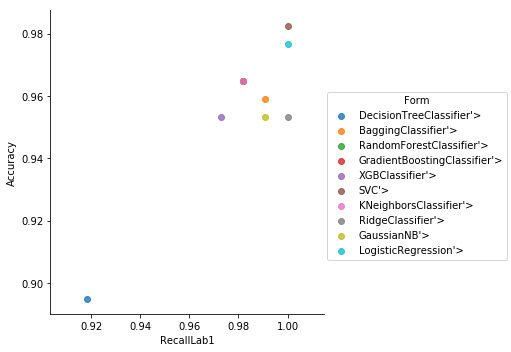

In [40]:
results['Form'] = [str(i).split()[-1].split('.')[-1] for i in to_run]
sb.lmplot('RecallLab1', 'Accuracy', hue='Form', data=results, fit_reg=False)

### Conclusion

In the case of the cancer patient detection, it would be very important to detect all the patients, in formal terms, to have the recall as high as possible for our model. From the above graph, we can observe that there are 3 models which are able to achieve perfect recall: Ridge classifier, logistic regression and support vector machine. In this scenario, the best way forward would be to pick the model with the highest accuracy among these models which is SVM.
Similar to the example in regression notebook, the simpler models such as logistic regression and ridge classifier perform better than ensemble models. 
I hope this module enables faster experimentation and provides an opportunity to build further customizations on top of it based on your needs!